In [1]:
import numpy as np
import sys
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Parallel_Simulation')
from Data_Treatement import *
import matplotlib.pyplot as plt
media = "/media/hcleroy/Simulation_Res/Parallel_Simulation_aging/time_equilibration_Nlinker/Batch_2/"
from matplotlib import colormaps
cm = colormaps['viridis']
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

In [19]:
NAMEs = ['N5','N10','N20','N30','N50']#,'N2_LE4','N5_LE4','N15_L10E4','N50_LE4']
NAMEs = ['N3','N5','N10','N20','N30','N50']
N = [3,5,10,20,30,50]
L = [10**3,10**3,10**3,10**3,10**3,10**3]

In [20]:
Clusters = list()
for name in NAMEs:
    print(name)
    Clusters.append(Data_Treatement(media+name+'.hdf',data_type='cluster'))
for cluster in Clusters:
    cluster.average(num_bins=100,log_scale=True)

N3
N5
N10
N20
N30
N50


In [21]:
def diff_eq( x,f, k, N):
    if k<=0:
        return 0
    return k**f   *f**2/N
def Fitting_function(x,k,N,n0):
    Solution = solve_ivp(diff_eq, (x[0], x[-1]), [n0], args=(k, N), t_eval=x, method='RK45')
    return np.clip(Solution.y[0], None, N)

In [22]:
def weighted_residuals(params, x, y):
    """Custom residuals function that applies weights."""
    predicted_y = Fitting_function(x, *params)
    # Weights could be adjusted here to reflect log scale importance
    # This is a simple version that gives equal weight to all points
    weights = 1 / (predicted_y + 1e-8)  # Avoid division by zero
    return (y - predicted_y) * weights

In [23]:
param_log = list()
param = list()
for i in range(len(Clusters)):
    popt,pconv = curve_fit(Fitting_function,Clusters[i].binned_time,Clusters[i].average_data[:,0],p0=(0.5,np.max(Clusters[i].average_data[:,0]),1))
    param.append(popt)
    initial_guess =(0.5,np.max(Clusters[i].average_data[:,0]),1)
    result = least_squares(weighted_residuals, initial_guess, args=(Clusters[i].binned_time,Clusters[i].average_data[:,0]))
    param_log.append(result.x)
param_log = np.array(param_log)

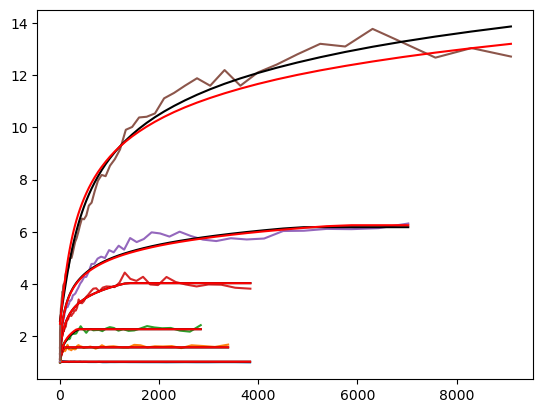

In [24]:
for i in range(len(Clusters)):
    plt.plot(Clusters[i].binned_time,Clusters[i].average_data[:,0])
    plt.plot(Clusters[i].binned_time,Fitting_function(Clusters[i].binned_time,*param[i]),color='black')
    plt.plot(Clusters[i].binned_time,Fitting_function(Clusters[i].binned_time,*param_log[i]),color='red')
#plt.xscale('log')

In [25]:
param_log

array([[1.54159575e-01, 1.03107859e+00, 1.00290952e+00],
       [1.98863077e-02, 1.58199580e+00, 1.03949074e+00],
       [3.61276295e-02, 2.27341781e+00, 1.14383595e+00],
       [1.04497805e-01, 4.03575386e+00, 1.35349835e+00],
       [1.78601129e-01, 6.25390966e+00, 1.60407064e+00],
       [4.81864398e-01, 5.68205085e+01, 2.48204531e+00]])

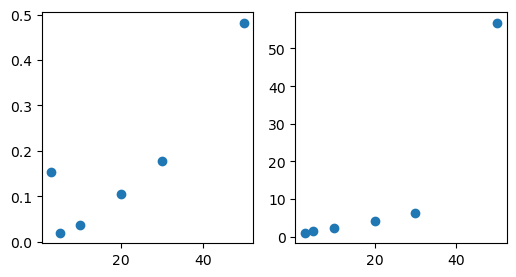

In [26]:
fig,ax = plt.subplots(ncols=2,figsize=(6,3))
ax[0].scatter(N,param_log[:,0])
ax[1].scatter(N,param_log[:,1])

## Now look at the ISF:

In [27]:
from scipy.optimize import curve_fit
#s_exp = lambda t,A,alpha,tau : A*np.exp(-(t/tau)**alpha) if alpha>0 else 0
def s_exp (t,A,alpha,tau):
    if tau>0 and A<=1.5:
        return A*np.exp(-(t/tau)**alpha)
    else:
        return 0.
name50 = ['N3','N5','N10','N20','N30','N50']#['N50_L10E3_Early.hdf','N50.hdf']
times_shift = list()
for name in name50:
    times_shift.append(np.mean(Data_Treatement(media+name+'.hdf',data_type='Time_shift').data,axis=0))
#time_shift = np.array([np.mean(times[i].data,axis=0) for i in range(len(name50))]).flatten().astype('float')

In [12]:
ISFs = list()
for name in name50:
    ISFs.append(Data_Treatement(media+name+'.hdf',data_type='ISF'))
for isf in ISFs:
    isf.average(num_bins=100,log_scale=True)

In [13]:
params=list()
i=0
for isfs in ISFs:
    print(i)
    i+=1
    param=list()
    for time,isf in zip(isfs.binned_time,isfs.average_data):
        popt,pconv = curve_fit(s_exp,time,isf,p0 = (1,1,100))
        param.append(popt)
    param = np.array(param)
    params.append(param)

0
1
2
3
4
5


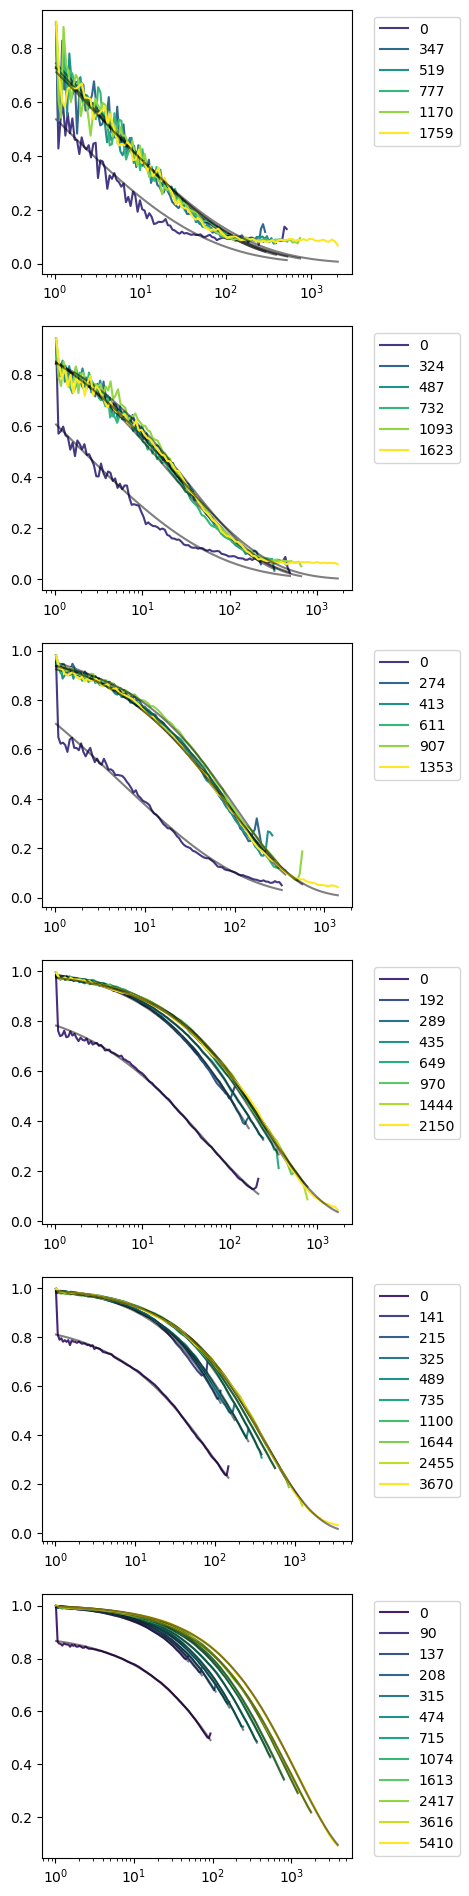

In [14]:
fig,ax = plt.subplots(nrows = len(name50),figsize=(4,4*len(name50)))
i=0
for n,isfs in enumerate(ISFs):
    Ntot = times_shift[n].shape[0]
    i=0
    for time,isf in zip(isfs.binned_time,isfs.average_data):
        ax[n].plot(time,isf,color=cm((i+1)/Ntot),label=int(times_shift[n][i]))        
        ax[n].plot(time,s_exp(time,*params[n][i]),color='black',alpha=0.5)
        i+=1    
        
    ax[n].set_xscale('log')
    ax[n].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

In [46]:
power_law = lambda t,alpha,A : A*t**alpha
power_param = list()
for n,time_shift in enumerate(times_shift):
    popt,pconv = curve_fit(lambda t,A : power_law(t,param_log[n,0],A),time_shift,params[n][:,2],p0 = (params[n][-1,2]/time_shift[-1])**param_log[n,0])
    power_param.append(popt)

In [47]:
power_param

[array([1.19647092]),
 array([24.59192899]),
 array([70.68532401]),
 array([112.28455491]),
 array([99.92909053]),
 array([20.17022633])]

(100.0, 1000.0)

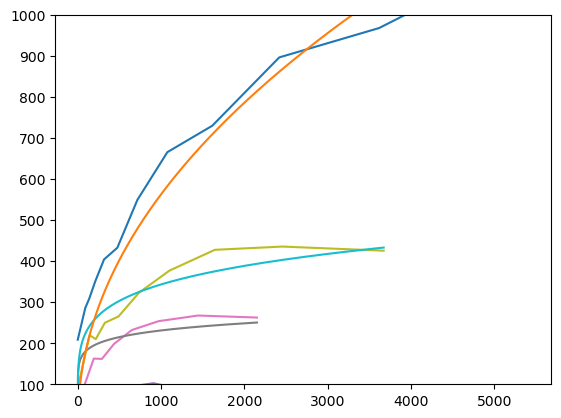

In [52]:
for n,time_shift in enumerate(times_shift):
    plt.plot(time_shift,params[n][:,2])
    #plt.plot(np.linspace(0,time_shift[-1],1000),(np.linspace(0,time_shift[-1],1000)/time_shift[-1])**param_log[n,0]*(params[n][-1,2]))
    plt.plot(np.linspace(0,time_shift[-1],1000),power_law(np.linspace(0,time_shift[-1],1000),param_log[n,0],power_param[n][0]))
#plt.yscale('log')
#plt.xscale('log')
#print(param[:,0])
#plt.xlim(-50,1000)
plt.ylim(100,1000)